## Лабораторная работа №2. Реализация глубокой нейронной сети

Перед запуском необходимо скачать файлы notMNIST_large.tar.gz и notMNIST_small.tar.gz, а затем разархивировать их в папку, где находится данный файл.

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, utils, regularizers, optimizers
from tensorflow.keras.models import Sequential

from mypackage import notmnist

Изображения сохраняются в формате pickle для быстрого получения в дальнейшем.

In [2]:
notmnist.save_data_set()

Поврежденное изображение notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png
Поврежденное изображение notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png
Поврежденное изображение notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png
Готово для notMNIST_large\A
Поврежденное изображение notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png
Готово для notMNIST_large\B
Готово для notMNIST_large\C
Поврежденное изображение notMNIST_large\D\VHJhbnNpdCBCb2xkLnR0Zg==.png
Готово для notMNIST_large\D
Готово для notMNIST_large\E
Готово для notMNIST_large\F
Готово для notMNIST_large\G
Готово для notMNIST_large\H
Готово для notMNIST_large\I
Готово для notMNIST_large\J

Поврежденное изображение notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
Готово для notMNIST_small\A
Готово для notMNIST_small\B
Готово для notMNIST_small\C
Готово для notMNIST_small\D
Готово для notMNIST_small\E
Поврежденное изображение notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png
Готово для notMNIS

Изображения разбиваются на обучающую, валидационную и контрольную подвыборки, таким же образом, как в 1-ой лабораторной работе.

In [3]:
large_data_set = notmnist.load_data_set(notmnist.LARGE_DATA_SET_FOLDER)
small_data_set = notmnist.load_data_set(notmnist.SMALL_DATA_SET_FOLDER)

In [4]:
def get_subset(data_set, size):
    subset = {}
    for class_name, images in data_set.items():
        subset[class_name] = random.sample(images, size // notmnist.NUMBER_OF_CLASSES)
    return subset

In [5]:
random.seed(7)
training_subset = get_subset(large_data_set, 200000)
validation_subset = get_subset(large_data_set, 10000)
control_subset = small_data_set

In [6]:
for class_name, images in training_subset.items():
    taken_images = {tuple(image.flatten()) for image in validation_subset[class_name] + control_subset[class_name]}
    training_subset[class_name] = [image for image in images if tuple(image.flatten()) not in taken_images]

Функция `get_samples` формирует матрицу признаков `X` и метки `y` для модели TensorFlow.

In [7]:
def get_samples(subset, size=None):
    X = []
    y = []

    for class_name, images in subset.items():
        if size is not None:
            images = images[:size // notmnist.NUMBER_OF_CLASSES]
        X = X + images
        y.extend([ord(class_name) - ord('A')] * len(images)) 
        
    X = tf.constant(X)  
    y = utils.to_categorical(tf.constant(y))
    return X, y

In [8]:
X, y = get_samples(training_subset)
val_X, val_y = get_samples(validation_subset)
control_X, control_y = get_samples(control_subset)

### Задание 1

Реализация полносвязной нейронной сети.

Модель имеет 3 скрытых слоя (512, 256, 128 нейронов) с кусочно-линейной функцией активации ReLU.

In [9]:
model = Sequential([
    layers.Rescaling(scale=1./255, offset=-0, input_shape=(28, 28, 1)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

Модель оптимизируется стохастическим градиентом SGD.

In [10]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

`plot_history` – отображает результаты функции потерь и точности

In [11]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Обучающая подвыборка')
    plt.plot(history.history['val_accuracy'], label='Валидационная подвыборка')
    plt.title('Точность модели')
    plt.ylabel('Точность')
    plt.xlabel('Эпоха')
    plt.legend(loc='upper left')
    plt.show()

`print_result` – выводит результаты для трех подвыборок

In [12]:
def print_result(history, control_loss, control_accuracy):
    training_loss = history.history['loss'][-1]
    training_accuracy = history.history['accuracy'][-1]
    validation_loss = history.history['val_loss'][-1]
    validation_accuracy = history.history['val_accuracy'][-1]
    
    print(f"обучающая подвыборка\t – потери: {training_loss:.4f} – точность: {training_accuracy:.4f}")
    print()
    print(f"валидационная подвыборка – потери: {validation_loss:.4f} – точность: {validation_accuracy:.4f}")
    print()
    print(f"контрольная подвыборка\t – потери: {control_loss:.4f} – точность: {control_accuracy:.4f}")

`fit_model` – тренирует модель и отображает результаты

In [13]:
def fit(model):
    return model.fit(
        X, 
        y, 
        batch_size=64, 
        epochs=30, 
        validation_data=(val_X, val_y), 
        verbose=0
    )

In [14]:
history = fit(model)

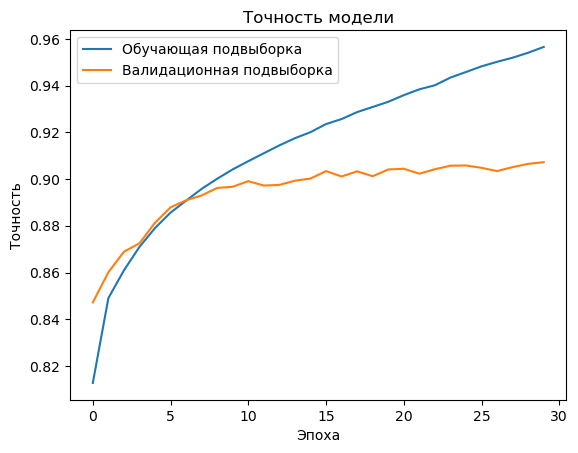

In [15]:
plot_history(history)

In [16]:
control_loss, control_accuracy = model.evaluate(control_X, control_y, verbose=0)
print_result(history, control_loss, control_accuracy)

обучающая подвыборка	 – потери: 0.1462 – точность: 0.9565

валидационная подвыборка – потери: 0.3601 – точность: 0.9072

контрольная подвыборка	 – потери: 0.1673 – точность: 0.9547


### Задание 2

Сравнение точности модели полносвязной нейронной сети с логистической регрессией.

**Точность логистической регрессии**: 89.73%

**Точность нейронной сети**:  95.47%

Нейронная сеть имеет более высокую точность по сравнению с логистической регрессией. 

### Задание 3

Использование регуляризации и метод сброса нейронов (dropout).

Для предотвращения переобучения используется функция *L2*. Также в процессе обучения в каждом скрытом слое отключается четверть нейронов.

In [17]:
model = Sequential([
    layers.Rescaling(scale=1./255, offset=-0, input_shape=(28, 28, 1)),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.25),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.25),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.25),
    layers.Dense(10, activation='softmax')
])

In [18]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = fit(model)

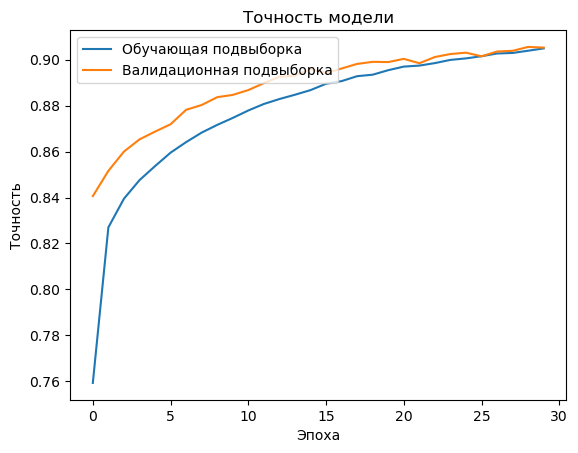

In [20]:
plot_history(history)

In [21]:
control_loss, control_accuracy = model.evaluate(control_X, control_y, verbose=0)
print_result(history, control_loss, control_accuracy)

обучающая подвыборка	 – потери: 0.4459 – точность: 0.9050

валидационная подвыборка – потери: 0.4383 – точность: 0.9053

контрольная подвыборка	 – потери: 0.2816 – точность: 0.9540


### Задание 4

Использование динамически изменяемой скорости обучения (learning rate).

In [22]:
model = Sequential([
    layers.Rescaling(scale=1./255, offset=-0, input_shape=(28, 28, 1)),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.25),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.25),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.25),
    layers.Dense(10, activation='softmax')
])

In [23]:
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

model.compile(
    optimizer=optimizers.SGD(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
history = fit(model)

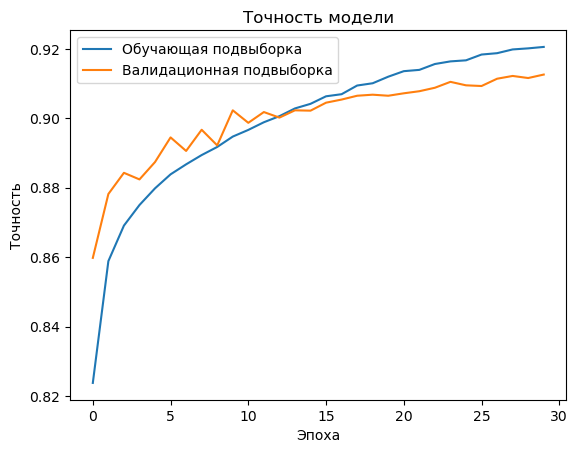

In [25]:
plot_history(history)

In [26]:
control_loss, control_accuracy = model.evaluate(control_X, control_y, verbose=0)
print_result(history, control_loss, control_accuracy)

обучающая подвыборка	 – потери: 0.3646 – точность: 0.9206

валидационная подвыборка – потери: 0.3874 – точность: 0.9126

контрольная подвыборка	 – потери: 0.2365 – точность: 0.9609
